## **Malaria Detection using a deep CNN with Dropout + proper weight initialization + Batch Normalization**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abrahamgenetutaye","key":"2f59722e846de26a34992f95947cbd04"}'}

In [ ]:
!ls -lha kaggle.json

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 73 Jun 24 05:16 kaggle.json


In [ ]:
!kaggle datasets list -s malaria


ref                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
imdevskp/malaria-dataset                            Malaria Dataset                                      52KB  2020-07-01 17:28:22           5742         88  1.0              
iarunava/cell-images-for-detecting-malaria          Malaria Cell Images Dataset                         675MB  2018-12-05 05:40:21          44400       1189  0.625            
kmader/malaria-bounding-boxes                       Malaria Bounding Boxes                                4GB  2019-05-09 13:37:54           3524        118  0.75             
miracle9to9/files1                                  Malaria Dataset                                     525MB  2020-01-0

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria  --force

100% 672M/675M [00:23<00:00, 33.0MB/s]
100% 675M/675M [00:23<00:00, 30.2MB/s]


In [ ]:
!unzip /content/cell-images-for-detecting-malaria.zip -d malaria-detection-dataset

Streaming output truncated to the last 5000 lines.
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png

### **Importing Libraries**

In [ ]:
# Import necessary libraries
import os
import cv2
import itertools
import shutil
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.utils import shuffle

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy, binary_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set seeds to ensure repeatability of results
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define the height and width of the images
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

# Specify the number of images to be held out for validation
NUM_HOLDOUT_IMAGES = 200

# Set the number of epochs to train the model for and the number of folds
NUM_EPOCHS = 20
NUM_FOLDS = 5

# Define the amount of padding to add to the images and the batch size
PADDING = 10
BATCH_SIZE = 10

# Set the number of epochs to train the final model for
NUM_FINAL_MODEL_EPOCHS = 10

In [ ]:
# Define the paths to the folders containing the uninfected and parasitized images
path_uninfected = 'malaria-detection-dataset/cell_images/Uninfected/'
path_parasitized = 'malaria-detection-dataset/cell_images/Parasitized/'

# Get the list of files in each folder
uninfected_list = os.listdir(path_uninfected)
parasitized_list = os.listdir(path_parasitized)

# Print the number of images in each folder
print('Uninfected: ', len(uninfected_list))
print('Parasitized: ', len(parasitized_list))

Uninfected:  13780
Parasitized:  13780


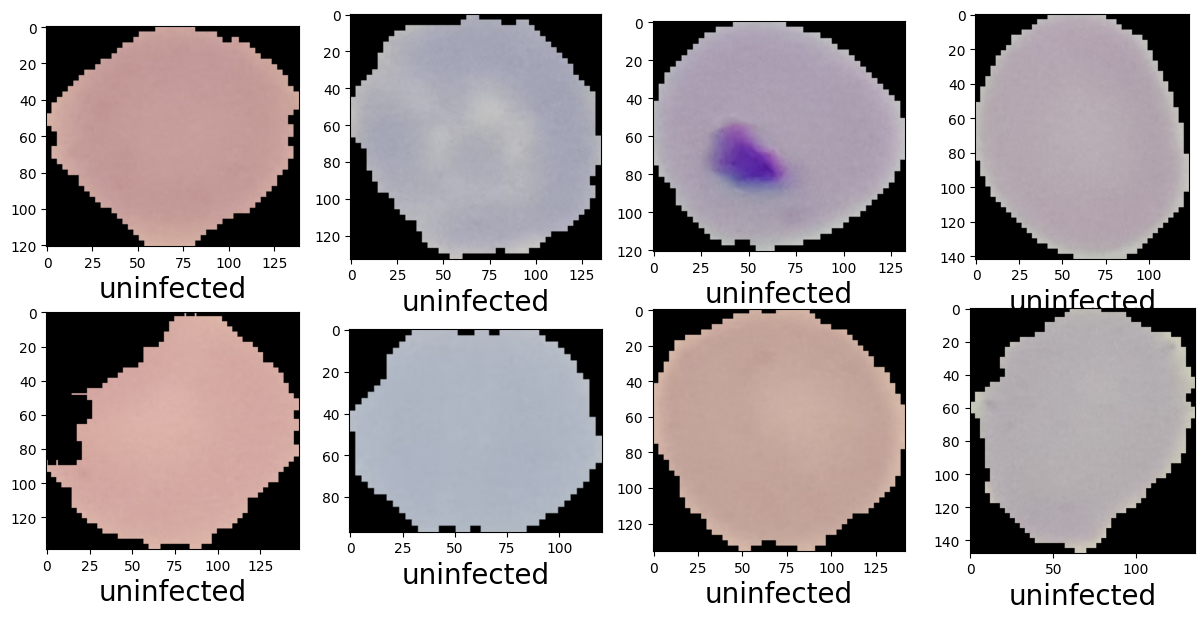

In [ ]:
# Set up the canvas for the subplots with a size of 20x10 inches
plt.figure(figsize=(15,7))

# Create a subplot grid with 2 rows and 4 columns
# The first subplot will be located at position 1
plt.subplot(2,4,1)

# Loop over 8 subplots, starting from position 1
for i in range(1,9):

    # Select the next subplot in the grid
    plt.subplot(2,4,i)

    # Get a random image from the uninfected list
    image = uninfected_list[i]

    # Read the image file from the uninfected folder and convert it to an array
    img_array = plt.imread(path_uninfected + image)

    # Display the image in the current subplot
    plt.imshow(img_array)

    # Set the xlabel of the current subplot to 'uninfected' with a font size of 20
    plt.xlabel('uninfected', fontsize=20)

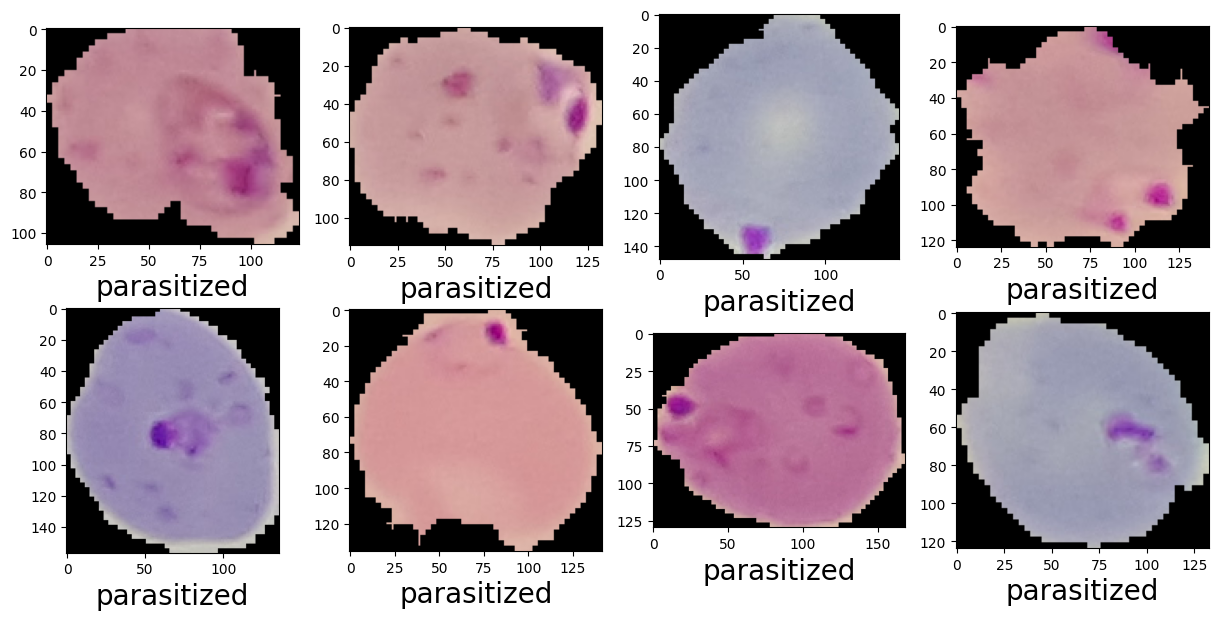

In [ ]:
# Set up the canvas for the subplots with a size of 20x10 inches
plt.figure(figsize=(15,7))

# Create a subplot grid with 2 rows and 4 columns
# The first subplot will be located at position 1
plt.subplot(2,4,1)

# Loop over 8 subplots, starting from position 1
for i in range(1,9):

    # Select the next subplot in the grid
    plt.subplot(2,4,i)

    # Get a random image from the parasitized list
    image = parasitized_list[i]

    # Read the image file from the parasitized folder and convert it to an array
    img_array = plt.imread(path_parasitized + image)

    # Display the image in the current subplot
    plt.imshow(img_array)

    # Set the xlabel of the current subplot to 'parasitized' with a font size of 20
    plt.xlabel('parasitized', fontsize=20)

In [ ]:
# Check if any non-image files are present in the parasitized folder
for item in parasitized_list:
    # Split the filename into a list using '.' as the separator
    file_list = item.split('.')

    # Check if the file extension is not 'png'
    if file_list[1] != 'png':
        # Print a message indicating the non-image file found in the parasitized folder
        print('Parasitized folder: ',item)

# Check if any non-image files are present in the uninfected folder
for item in uninfected_list:
    # Split the filename into a list using '.' as the separator
    file_list = item.split('.')

    # Check if the file extension is not 'png'
    if file_list[1] != 'png':
        # Print a message indicating the non-image file found in the uninfected folder
        print('Uninfected folder: ', item)

Parasitized folder:  Thumbs.db
Uninfected folder:  Thumbs.db


### **Put the image names into dataframes**
Here we will create a dataframe called df_combined that includes both uninfected and parasitized images. This new dataframe will have a column showing the target class of each image.

In [ ]:
# Create a dataframe for the uninfected images with a single column 'image_id' containing the image filenames
df_uninfected = pd.DataFrame(uninfected_list, columns=['image_id'])

# Remove any rows with the image filename 'Thumbs.db' from the uninfected dataframe
df_uninfected = df_uninfected[df_uninfected['image_id'] != 'Thumbs.db']

# Add a new column 'target' to the uninfected dataframe with all values set to 0
df_uninfected['target'] = 0

# Create a dataframe for the parasitized images with a single column 'image_id' containing the image filenames
df_parasitized = pd.DataFrame(parasitized_list, columns=['image_id'])

# Remove any rows with the image filename 'Thumbs.db' from the parasitized dataframe
df_parasitized = df_parasitized[df_parasitized['image_id'] != 'Thumbs.db']

# Add a new column 'target' to the parasitized dataframe with all values set to 1
df_parasitized['target'] = 1

# Print the shapes of the uninfected and parasitized dataframes
print(df_uninfected.shape)
print(df_parasitized.shape)

# Concatenate the uninfected and parasitized dataframes into a single dataframe, and reset the index
df_combined = pd.concat([df_uninfected, df_parasitized], axis=0).reset_index(drop=True)

# Print the shape of the combined dataframe
print(df_combined.shape)
# Check if the image names are unique.
# The output should be 27558

df_combined['image_id'].nunique()

(13779, 2)
(13779, 2)
(27558, 2)


27558

In [ ]:
df_combined.head()

,image_id,target
0,C187P148NThinF_IMG_20151203_154111_cell_54.png,0
1,C81P42ThinF_IMG_20150817_121113_cell_154.png,0
2,C178P139NThinF_IMG_20151201_154337_cell_110.png,0
3,C210ThinF_IMG_20151029_162934_cell_258.png,0
4,C231ThinF_IMG_20151112_153246_cell_212.png,0


In [ ]:
import cv2

def read_image_sizes(file_name):
    """
    This function reads an image file and returns its shape, max and min pixel values, and image format.
    """

    # Determine the path to the image file based on whether it is uninfected or parasitized
    if file_name in uninfected_list:
        path = path_uninfected
    else:
        path = path_parasitized

    # Read the image file using OpenCV
    image = cv2.imread(path + file_name)

    # Compute the max and min pixel values in the image
    max_pixel_val = image.max()
    min_pixel_val = image.min()

    # Extract the image format from the filename
    img_format = file_name.split('.')[1]

    # Return a list containing the image shape, max and min pixel values, and image format
    output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val, img_format]
    return output

# Apply the read_image_sizes function to each image in df_combined['image_id'], and stack the resulting arrays row-wise
m = np.stack(df_combined['image_id'].apply(read_image_sizes))

# Create a new dataframe 'df' from the stacked array, with column names 'w', 'h', 'c', 'max_pixel_val', 'min_pixel_val', and 'image_format'
df = pd.DataFrame(m, columns=['w','h','c','max_pixel_val','min_pixel_val', 'image_format'])

# Concatenate the original dataframe df_combined with the new dataframe df along axis 1, and set sort=False to suppress a warning message
df_combined = pd.concat([df_combined,df], axis=1, sort=False)

# Print the first 10 rows of the combined dataframe
df_combined.head(10)

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
0,C187P148NThinF_IMG_20151203_154111_cell_54.png,0,121,121,3,197,0,png
1,C81P42ThinF_IMG_20150817_121113_cell_154.png,0,121,139,3,218,0,png
2,C178P139NThinF_IMG_20151201_154337_cell_110.png,0,133,136,3,204,0,png
3,C210ThinF_IMG_20151029_162934_cell_258.png,0,121,133,3,201,0,png
4,C231ThinF_IMG_20151112_153246_cell_212.png,0,142,124,3,200,0,png
5,C91P52ThinF_IMG_20150821_124937_cell_167.png,0,139,148,3,224,0,png
6,C187P148NThinF_IMG_20151203_153713_cell_98.png,0,97,121,3,206,0,png
7,C96P57ThinF_IMG_20150824_112132_cell_53.png,0,136,142,3,218,0,png
8,C172P133ThinF_IMG_20151119_155019_cell_169.png,0,148,136,3,211,0,png
9,C181P142ThinF_IMG_20151127_160434_cell_116.png,0,112,115,3,199,0,png


In [ ]:
# Check if all images have 3 channels
df_combined['c'].value_counts()

# Check if all images are in png format
df_combined['image_format'].value_counts()

png    27558
Name: image_format, dtype: int64

In [ ]:
df_combined = shuffle(df_combined, random_state=101)

# create a holdout set with 200 samples
df_holdout = df_combined.sample(NUM_HOLDOUT_IMAGES, random_state=101)

# create a list of holdout images
holdout_images_list = list(df_holdout['image_id'])


# Select only rows that are not part of the holdout set.
# Note the use of ~ to execute 'not in'.
df_data = df_combined[~df_combined['image_id'].isin(holdout_images_list)]

In [ ]:
df_holdout.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
12152,C184P145ThinF_IMG_20151203_102543_cell_112.png,0,136,172,3,202,0,png
24272,C180P141NThinF_IMG_20151201_165601_cell_190.png,1,127,133,3,210,0,png
16731,C89P50ThinF_IMG_20150820_163728_cell_190.png,1,157,142,3,219,0,png
22176,C68P29N_ThinF_IMG_20150819_133236_cell_153.png,1,148,145,3,225,0,png
25394,C132P93ThinF_IMG_20151004_153030_cell_35.png,1,124,118,3,236,0,png


In [ ]:
# Check the shapes.
# The ouput should be:
# (200, 8)
# (27358, 8)

print(df_holdout.shape)
print(df_data.shape)

(200, 8)
(27358, 8)


In [ ]:
# Check the target distribution in the holdout set.
# 0 = uninfected
# 1 = parasitized

df_holdout['target'].value_counts()

1    104
0     96
Name: target, dtype: int64

# **Train-Test-Split Model**
Train-test-split is not the ideal way to assess model perfromance. However, it's a good starting point because it's simple to set up and runs 5 times faster than 5 fold cross validation. This helps us to:

In [ ]:
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # a_uninfected
    # b_parasitized

# val
    # a_uninfected
    # b_parasitized


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_uninfected = os.path.join(train_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(train_dir, 'b_parasitized')
os.mkdir(b_parasitized)


# create new folders inside val_dir
a_uninfected = os.path.join(val_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(val_dir, 'b_parasitized')
os.mkdir(b_parasitized)

In [ ]:
# check if base_dir has been created
!ls

base_dir			       kaggle.json		  sample_data
cell-images-for-detecting-malaria.zip  malaria-detection-dataset


In [ ]:
# see what's inside base_dir
os.listdir('base_dir')

['train_dir', 'val_dir']

### **Create the Train and Val Sets**
We will create a stratified val set. This means that the val set will have the same target distribution as the train set. Actually doing stratification isn't essential here because the target is balanced. Because of this there's a good chance that randomly selecting rows will still result in the val set having a fairly balanced target distribution. Stratification is more applicable for data where the target is unbalanced.

In [ ]:
# select the column that we will use for stratification
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(23254, 8)
(4104, 8)


In [ ]:
# Check the target distribution of the val set.
# The target should be approx balanced.

df_val['target'].value_counts()

0    2053
1    2051
Name: target, dtype: int64

In [ ]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
df_data.head()

,target,w,h,c,max_pixel_val,min_pixel_val,image_format
image_id,,,,,,,
C106P67ThinF_IMG_20150924_103811_cell_70.png,0,160,148,3,223,0,png
C51AP12thinF_IMG_20150724_154330_cell_120.png,1,76,97,3,224,0,png
C176P137NThinF_IMG_20151201_121808_cell_133.png,1,127,115,3,216,0,png
C39P4thinF_original_IMG_20150622_114804_cell_20.png,1,151,115,3,220,0,png
C128P89ThinF_IMG_20151004_131030_cell_157.png,1,151,136,3,222,0,png


In [ ]:
path_uninfected = 'malaria-detection-dataset/cell_images/Uninfected/'
path_parasitized = 'malaria-detection-dataset/cell_images/Parasitized/'

# Get a list of images in each of the two folders
folder_1 = os.listdir(path_uninfected)
folder_2 = os.listdir(path_parasitized)

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:

    fname = image
    target = df_data.loc[image,'target']

    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'

    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)



# Transfer the val images

for image in val_list:

    fname = image
    target = df_data.loc[image,'target']


    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'


    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst

In [ ]:
# Print the number of images in each folder

# train
print(len(os.listdir('base_dir/train_dir/a_uninfected')))
print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

# val
print(len(os.listdir('base_dir/val_dir/a_uninfected')))
print(len(os.listdir('base_dir/val_dir/b_parasitized/')))

11630
11624
2053
2051


In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# Note that here we are normalizing the images inside the generator.
# If you wanted to add some data augmentation you could do it here.
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 23254 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.


## **Building a deep CNN with Dropout + proper weight initialization + Batch Normalization + Zero Padding**


In [ ]:
from tensorflow.keras import optimizers

# Defining some of the model parameters
# Create folder if it doesn't exist
if not os.path.exists("Models"):
    os.mkdir("Models")
#model_save_path = "C:/Users/uytu/Desktop/Prince/Malaria Malware Detection Jupyter Notebook/Models/"
input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
epochs = 20
batch_size = 20

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.3
padding = 1 # zero padding size

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(BatchNormalization())
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-6),
              metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_80 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 conv2d_81 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 45, 45, 32)        0         
                                                                 
 conv2d_82 (Conv2D)          (None, 43, 43, 64)        18496     
                                                     

In [ ]:

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-6),
              metrics=['accuracy'])

In [ ]:
filepath = "Models/malaria_model3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')


callbacks_list = [checkpoint]

history = model.fit(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=NUM_EPOCHS, verbose=1,
                           callbacks=callbacks_list)

## **Evaluate the model using the val set**

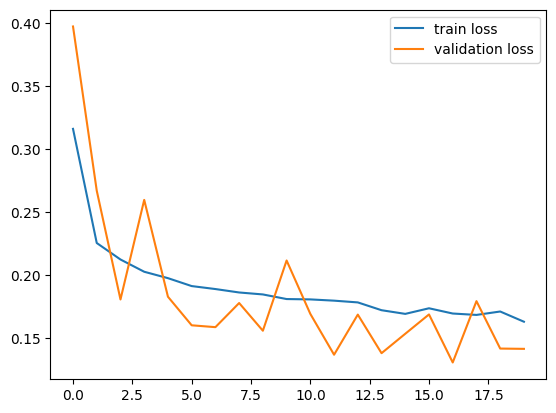

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

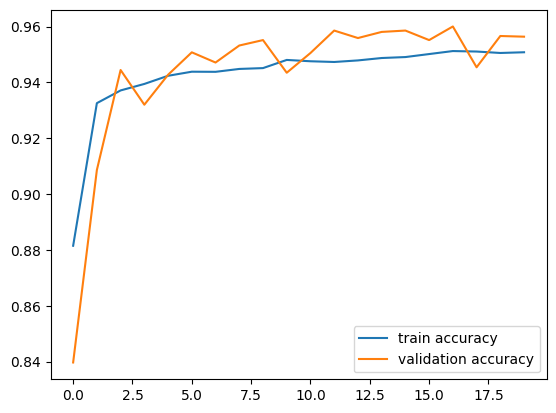

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
#Saving this state of the model as h5 file
model.save('malaria_model3.h5')

from google.colab import files
files.download('malaria_model3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [ ]:
# Here the best epoch will be used.

model.load_weights('malaria_model3.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen,
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

<ipython-input-52-bf808e66caf1>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen,


val_loss: 0.1411740928888321
val_acc: 0.956384003162384


### **Create a Confusion Matrix**

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
# Print the label associated with each class
test_gen.class_indices

{'a_uninfected': 0, 'b_parasitized': 1}

In [ ]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)

<ipython-input-57-82d2c123f4cd>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)


411/411 [==============================] - 4s 10ms/step


In [ ]:
# If you wanted to get the image_id's to match them to predictions this
# is how to do it.

test_gen.filenames

['a_uninfected/C100P61ThinF_IMG_20150918_144348_cell_131.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_144348_cell_71.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_144823_cell_126.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_144823_cell_34.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_144823_cell_71.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_145042_cell_33.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_145042_cell_81.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_145609_cell_48.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_145938_cell_64.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151149_cell_34.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151335_cell_22.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151335_cell_24.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151942_cell_39.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151942_cell_56.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_155731_cell_24.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_155731_cell_37.png',
 'a_un

In [ ]:
# check the number of predictions
predictions.shape

(4104, 2)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

(4104,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_gen.class_indices

{'a_uninfected': 0, 'b_parasitized': 1}

Confusion matrix, without normalization
[[1994   59]
 [ 120 1931]]


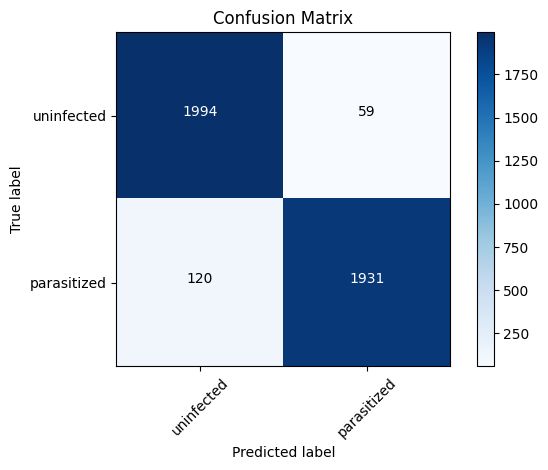

In [ ]:
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['uninfected', 'parasitized']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### **Create a Classification Report**

In [ ]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

**Recall** = Given a class, will the classifier be able to detect it?

**Precision** = Given a class prediction from a classifier, how likely is it to be correct?

**F1** **Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

In [ ]:
# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

  uninfected       0.94      0.97      0.96      2053
 parasitized       0.97      0.94      0.96      2051

    accuracy                           0.96      4104
   macro avg       0.96      0.96      0.96      4104
weighted avg       0.96      0.96      0.96      4104



### **Error Analysis**

In [ ]:
# put the val image_id, labels and predictions into a dataframe

val_pred_dict = {
    'image_id': test_gen.filenames,
    'val_labels': test_gen.classes,
    'val_preds': predictions.argmax(axis=1)
}

df_val_preds = pd.DataFrame(val_pred_dict)


# Adjust the file names

# sample image name: a_uninfected/C100P61ThinF_IMG_20150918_144104_...
# we want just this part: C100P61ThinF_IMG_20150918_144104_...

def adjust_file_names(x):
    # split into a list based on '/'
    fname = x.split('/')
    # chose the second item in the list which is the image name
    fname = fname[1]

    return fname

df_val_preds['image_id'] = df_val_preds['image_id'].apply(adjust_file_names)


# savedf_val_preds so we can analyze the results later
pickle.dump(df_val_preds,open('df_val_preds.pickle','wb'))

# code to load the dataframe
# df_val_preds = pickle.load(open('df_val_preds','rb'))


#df_val_preds.head()

In [ ]:
df_val_preds.head()

,image_id,val_labels,val_preds
0,C100P61ThinF_IMG_20150918_144348_cell_131.png,0,0
1,C100P61ThinF_IMG_20150918_144348_cell_71.png,0,0
2,C100P61ThinF_IMG_20150918_144823_cell_126.png,0,0
3,C100P61ThinF_IMG_20150918_144823_cell_34.png,0,0
4,C100P61ThinF_IMG_20150918_144823_cell_71.png,0,0


In [ ]:
# filter out those rows where the model made correct predictions
df_correct = df_val_preds[df_val_preds['val_labels'] == df_val_preds['val_preds']]

# filter out those rows where the model made wrong predictions
df_wrong = df_val_preds[df_val_preds['val_labels'] != df_val_preds['val_preds']]

print(df_correct.shape)
print(df_wrong.shape)

(3925, 3)
(179, 3)


**Analyze the correct predictions**

In [ ]:
df_correct.head()

,image_id,val_labels,val_preds
0,C100P61ThinF_IMG_20150918_144348_cell_131.png,0,0
1,C100P61ThinF_IMG_20150918_144348_cell_71.png,0,0
2,C100P61ThinF_IMG_20150918_144823_cell_126.png,0,0
3,C100P61ThinF_IMG_20150918_144823_cell_34.png,0,0
4,C100P61ThinF_IMG_20150918_144823_cell_71.png,0,0


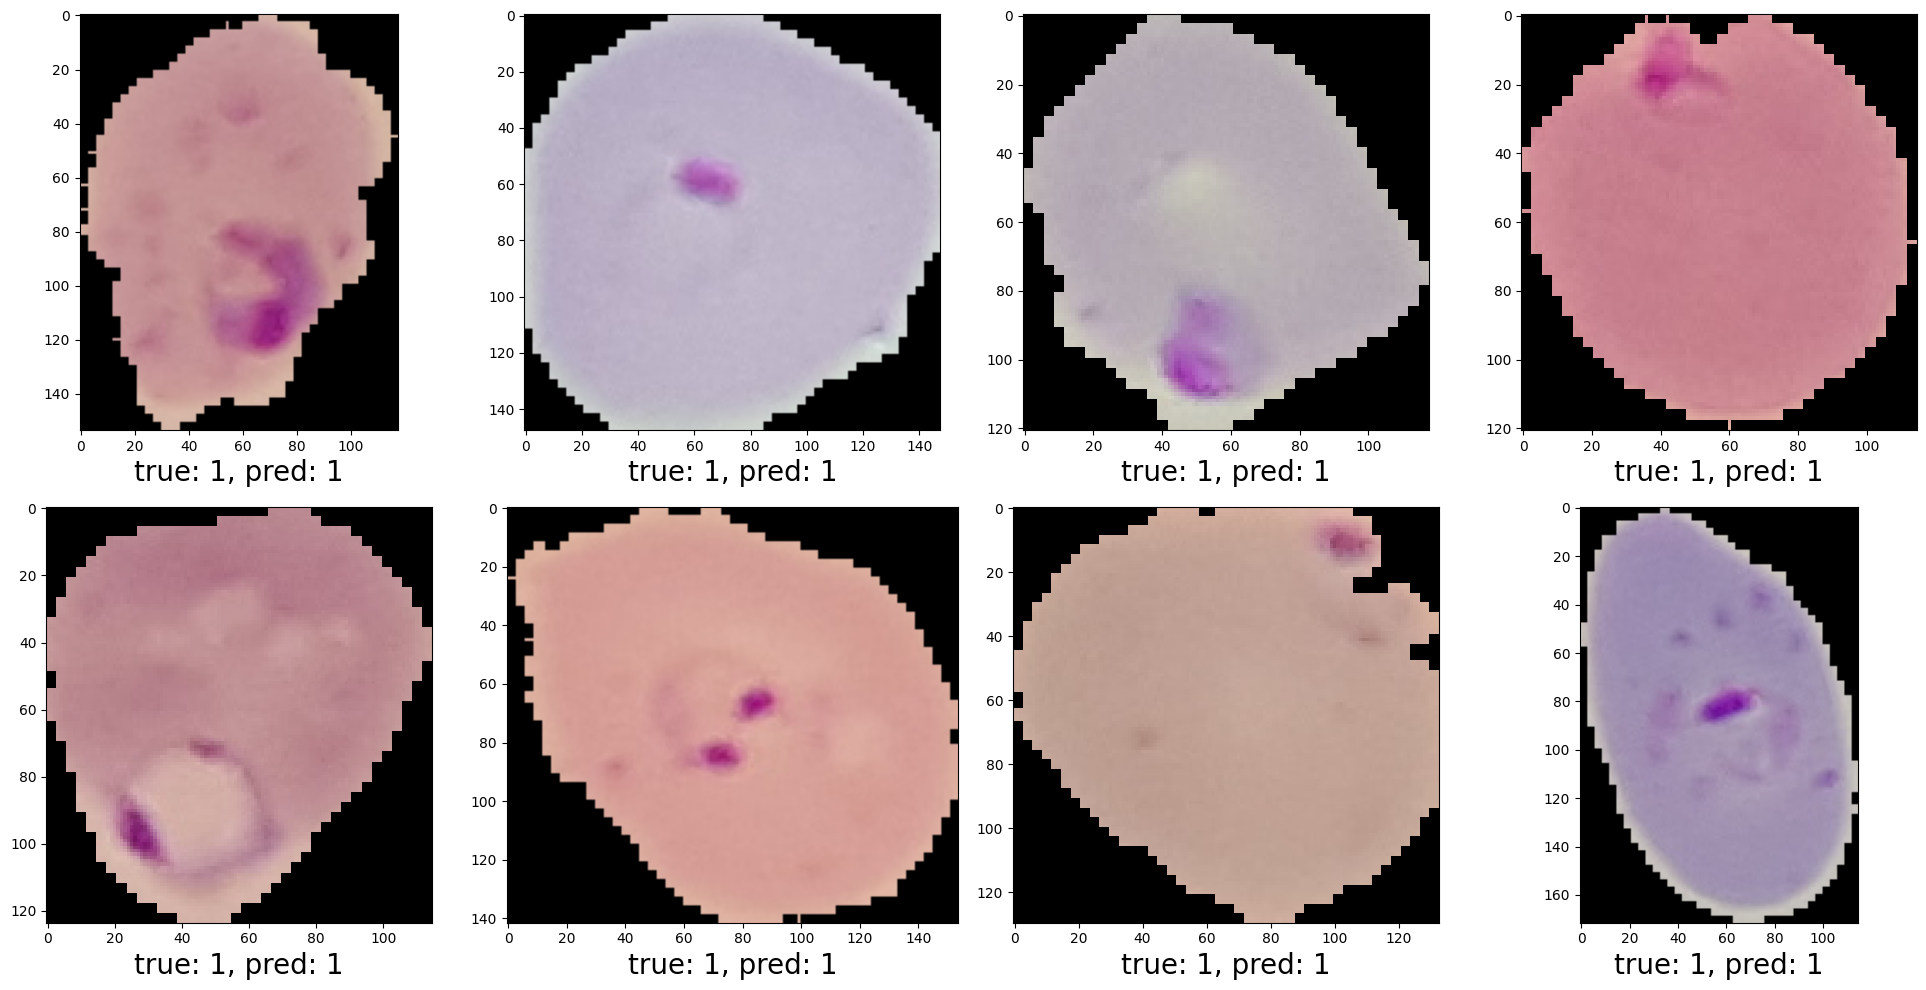

In [ ]:

df_1 = df_correct[df_correct['val_labels'] == 1]

# we see diffrent images each time the code is run.
# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):

    plt.subplot(2,4,i)

    # get a random image
    image_list = list(df_1['image_id'].sample(1))
    image = image_list[0]

    # display the image
    plt.imshow(plt.imread(path_parasitized + image))

    plt.tight_layout()

    plt.xlabel('true: 1, pred: 1', fontsize=20)


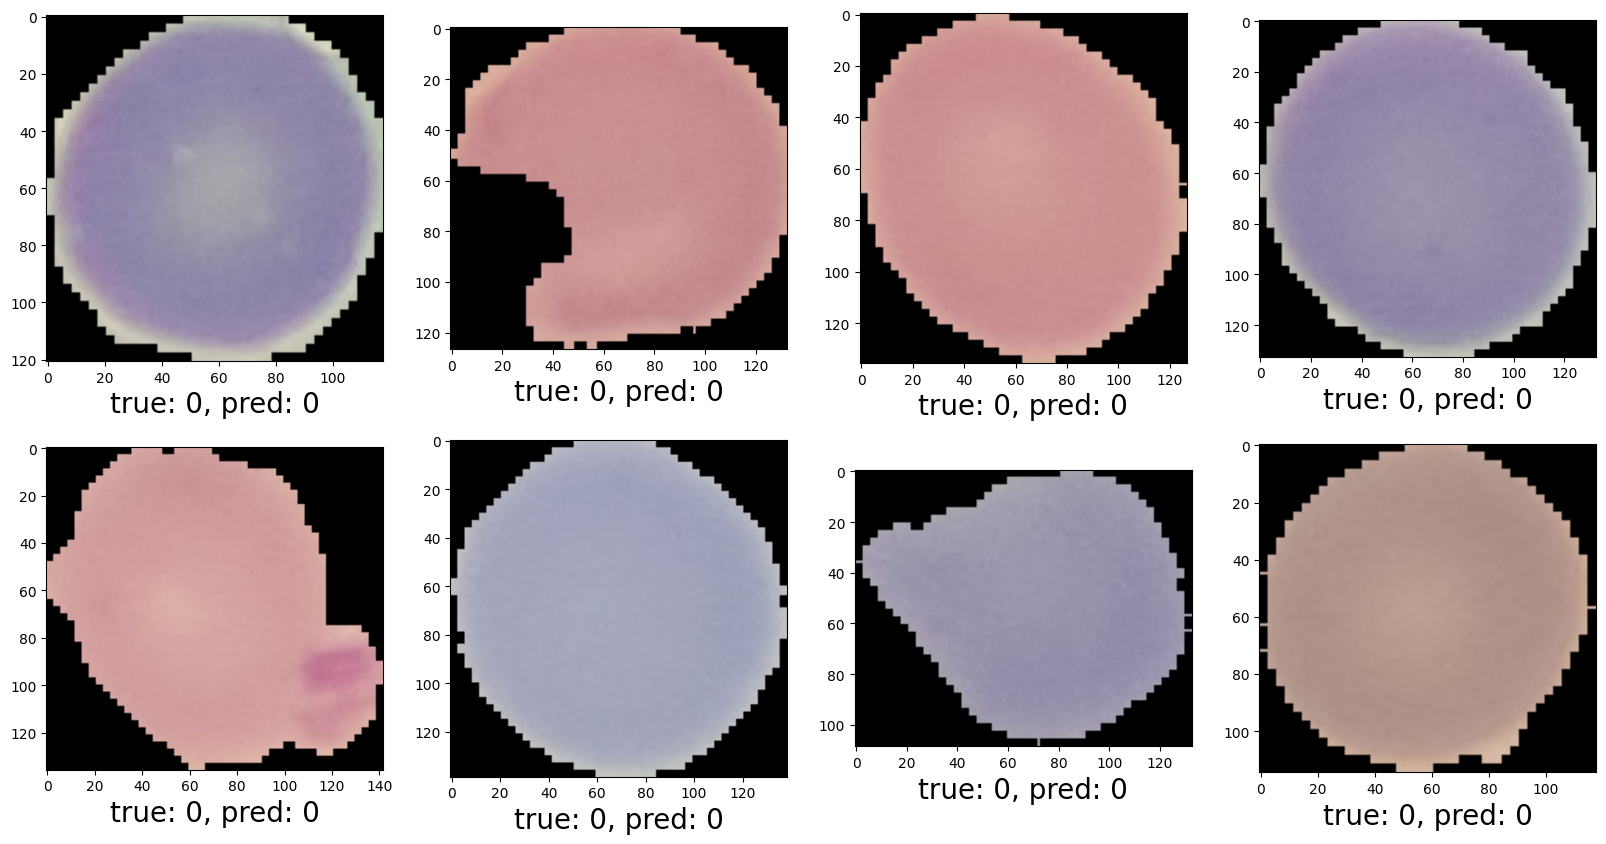

In [ ]:

df_0 = df_correct[df_correct['val_labels'] == 0]

# we see diffrent images each time the code is run.
# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):

    plt.subplot(2,4,i)

    # get a random image
    image_list = list(df_0['image_id'].sample(1))
    image = image_list[0]

    # display the image
    plt.imshow(plt.imread(path_uninfected + image))

    plt.xlabel('true: 0, pred: 0', fontsize=20)

**Analyze the wrong predictions**

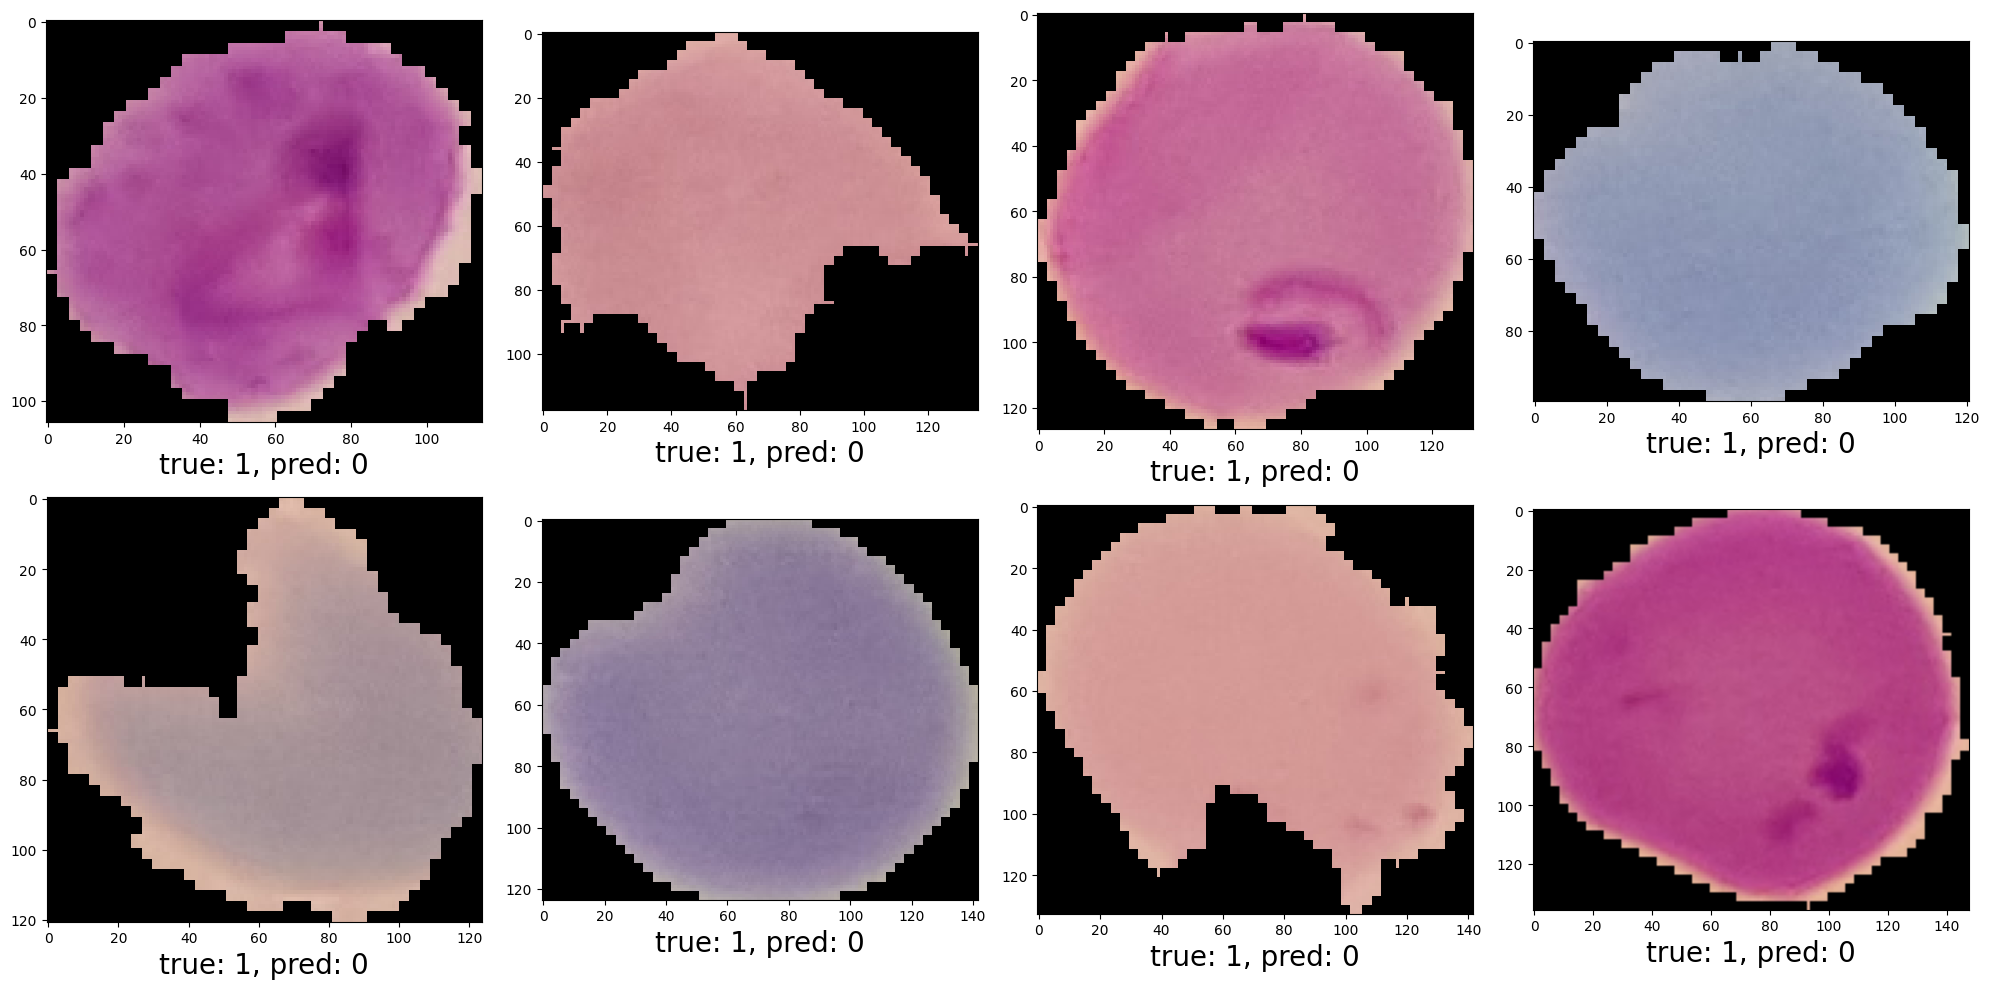

In [ ]:

df_1 = df_wrong[df_wrong['val_labels'] == 1]


# Note that this chooses random images. Therefore,
# we see diffrent images each time the code is run.

# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):

    plt.subplot(2,4,i)

    # get a random image
    image_list = list(df_1['image_id'].sample(1))
    image = image_list[0]

    # display the image
    plt.imshow(plt.imread(path_parasitized + image))

    plt.tight_layout()

    plt.xlabel('true: 1, pred: 0', fontsize=20)

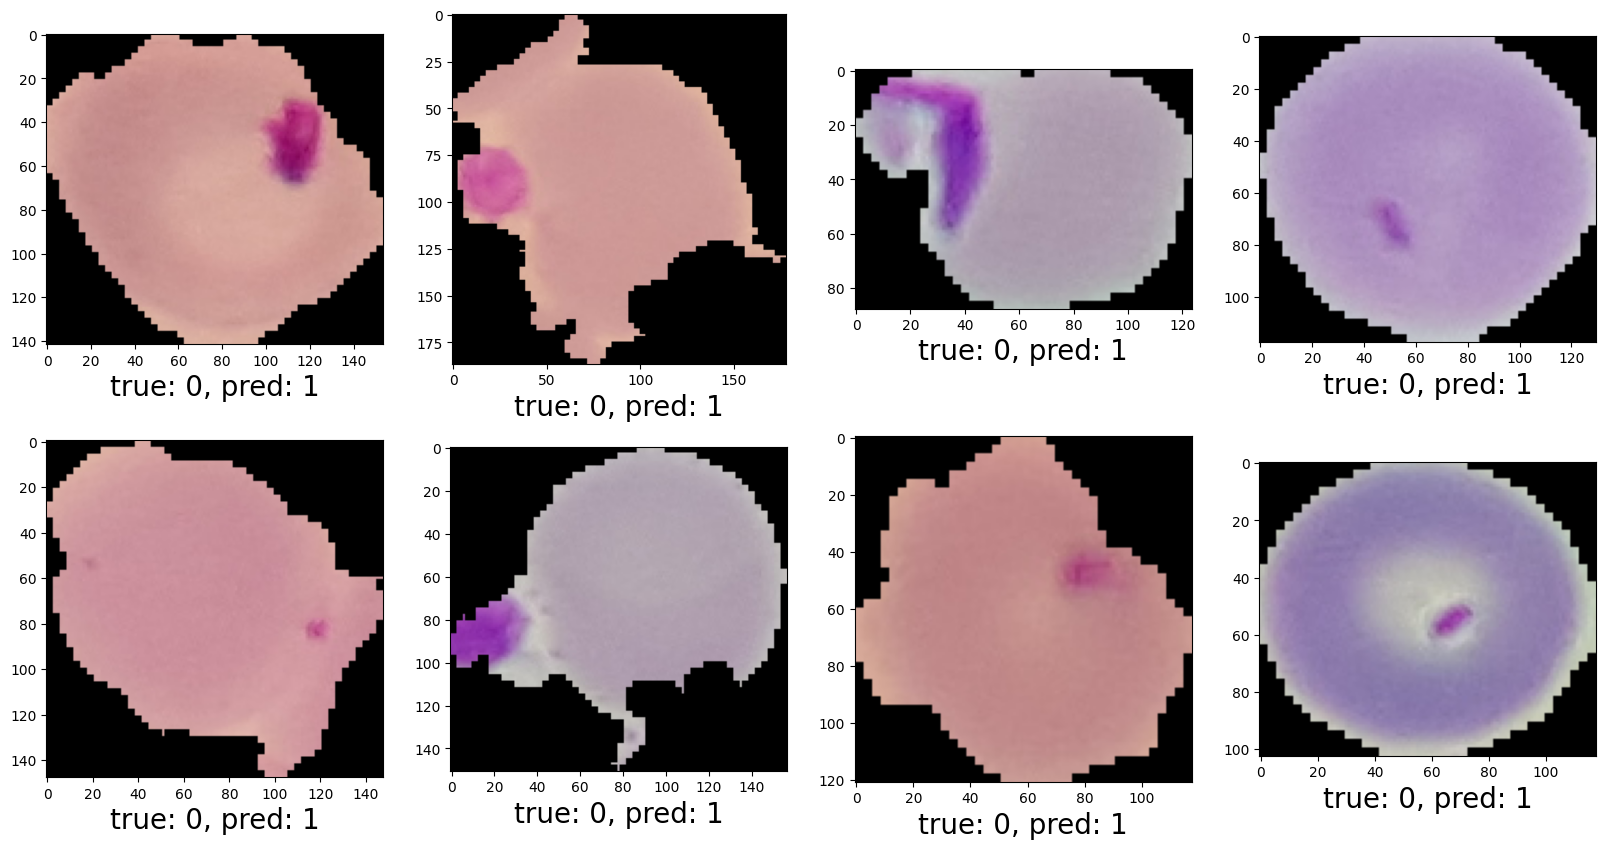

In [ ]:
#
df_0 = df_wrong[df_wrong['val_labels'] == 0]

# Note that this chooses random images. Therefore,
# we see diffrent images each time the code is run.

# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):

    plt.subplot(2,4,i)

    # get a random image
    image_list = list(df_0['image_id'].sample(1))
    image = image_list[0]

    # display the image
    plt.imshow(plt.imread(path_uninfected + image))

    plt.xlabel('true: 0, pred: 1', fontsize=20)

### **Observation and Comments**
In cases where the label was parasitized but the model predicted uninfected I noticed that the blue-ish area was located close to the edge of the image. Could it be that the model was not detecting important patterns that are located at the edge of images? To address this issue I decided to add a padding layer to the model arcitecture. This layer added a 10 pixel zero padding around each image. I found that the cross validation scores improved after this change.

When doing this error analysis our premise has been that if there is a mismatch between the label and the prediction then the model has made a mistake. However, there's another possibility - the model prediction is correct. There are 27,558 images in this dataset. All images were examined and labeled by the same expert. This must've been a tedious and time consuming process so it's possible that some images were incorrectly labeled.

At this point it would be helpful to collaborate with a domain expert in order to discuss possible reasons for the mistakes this model is making. Are they the result of model weakness, incorrect labels or maybe damaged images? Is the correct label easy for a human to classify or would a human struggle to make a correct diagnosis? What are the main indicators that an expert looks for when examining cell images? Is the model seeing things that an expert didn't notice?

## **Convert the final model from Keras to Tensorflow.js**

In [ ]:
# Python
!pip install tensorflowjs
import tensorflowjs as tfjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.10
    Uninstalling flax-0.6.10:
      Successfully uninstalled flax-0.6.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.


In [ ]:
!tensorflowjs_converter --input_format keras malaria_model3.h5 tfjs/model


2023-06-24 06:12:00.434383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# check that the tfjs files exist
import os
os.listdir('tfjs/model')

['group1-shard2of2.bin', 'model.json', 'group1-shard1of2.bin']